In [4]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load
import warnings

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
import re
import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import GRU
from keras.layers import concatenate
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.resnet_v2 import ResNet152V2, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
 !pip install Keras-Preprocessing

  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)


In [3]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.2.0

Found existing installation: tensorflow 1.13.1
Uninstalling tensorflow-1.13.1:
  Successfully uninstalled tensorflow-1.13.1
     -------------------------------------- 459.2/459.2 MB 4.1 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 9.9 MB/s eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 10.5 MB/s eta 0:00:00
     -------------------------------------- 454.6/454.6 kB 9.5 MB/s eta 0:00:00
     ---------------------------------------- 30.9/30.9 MB 7.2 MB/s eta 0:00:00
     ---------------------------------------- 152.9/152.9 kB ? eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimator-1.13.0:
      Successfully uninstalled tensorflow-estimator-1.13.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: h5py
    Found existi

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\akash\\AppData\\Local\\Programs\\Python\\Python37\\Lib\\site-packages\\tensorflow\\python\\_pywrap_py_exception_registry.pyd'
Consider using the `--user` option or check the permissions.



In [6]:
import os
image_path = "../Image Captioning/DataSet/Images/"
dir_Flickr_text = "../Image Captioning/DataSet/Flickr8k_text/flickr8k.token.txt"
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 8091


In [9]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   pre_col = line.split()
   if len(pre_col) == 0:
       continue
   col = []
   col.append(pre_col[0])
   col.append(' '.join(pre_col[1:]))
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()


index                   filename  \
0     0  1000268201_693b08cb0e.jpg   
1     1  1000268201_693b08cb0e.jpg   
2     2  1000268201_693b08cb0e.jpg   
3     3  1000268201_693b08cb0e.jpg   
4     4  1000268201_693b08cb0e.jpg   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...

In [10]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8918


In [11]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text): 
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

In [12]:
clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8357


In [13]:
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [14]:
PATH = "../Image Captioning/DataSet/Images/"
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['../Image Captioning/DataSet/Images/1000268201_693b08cb0e.jpg',
 '../Image Captioning/DataSet/Images/1000268201_693b08cb0e.jpg',
 '../Image Captioning/DataSet/Images/1000268201_693b08cb0e.jpg',
 '../Image Captioning/DataSet/Images/1000268201_693b08cb0e.jpg',
 '../Image Captioning/DataSet/Images/1000268201_693b08cb0e.jpg',
 '../Image Captioning/DataSet/Images/1001773457_577c3a7d70.jpg',
 '../Image Captioning/DataSet/Images/1001773457_577c3a7d70.jpg',
 '../Image Captioning/DataSet/Images/1001773457_577c3a7d70.jpg',
 '../Image Captioning/DataSet/Images/1001773457_577c3a7d70.jpg',
 '../Image Captioning/DataSet/Images/1001773457_577c3a7d70.jpg']

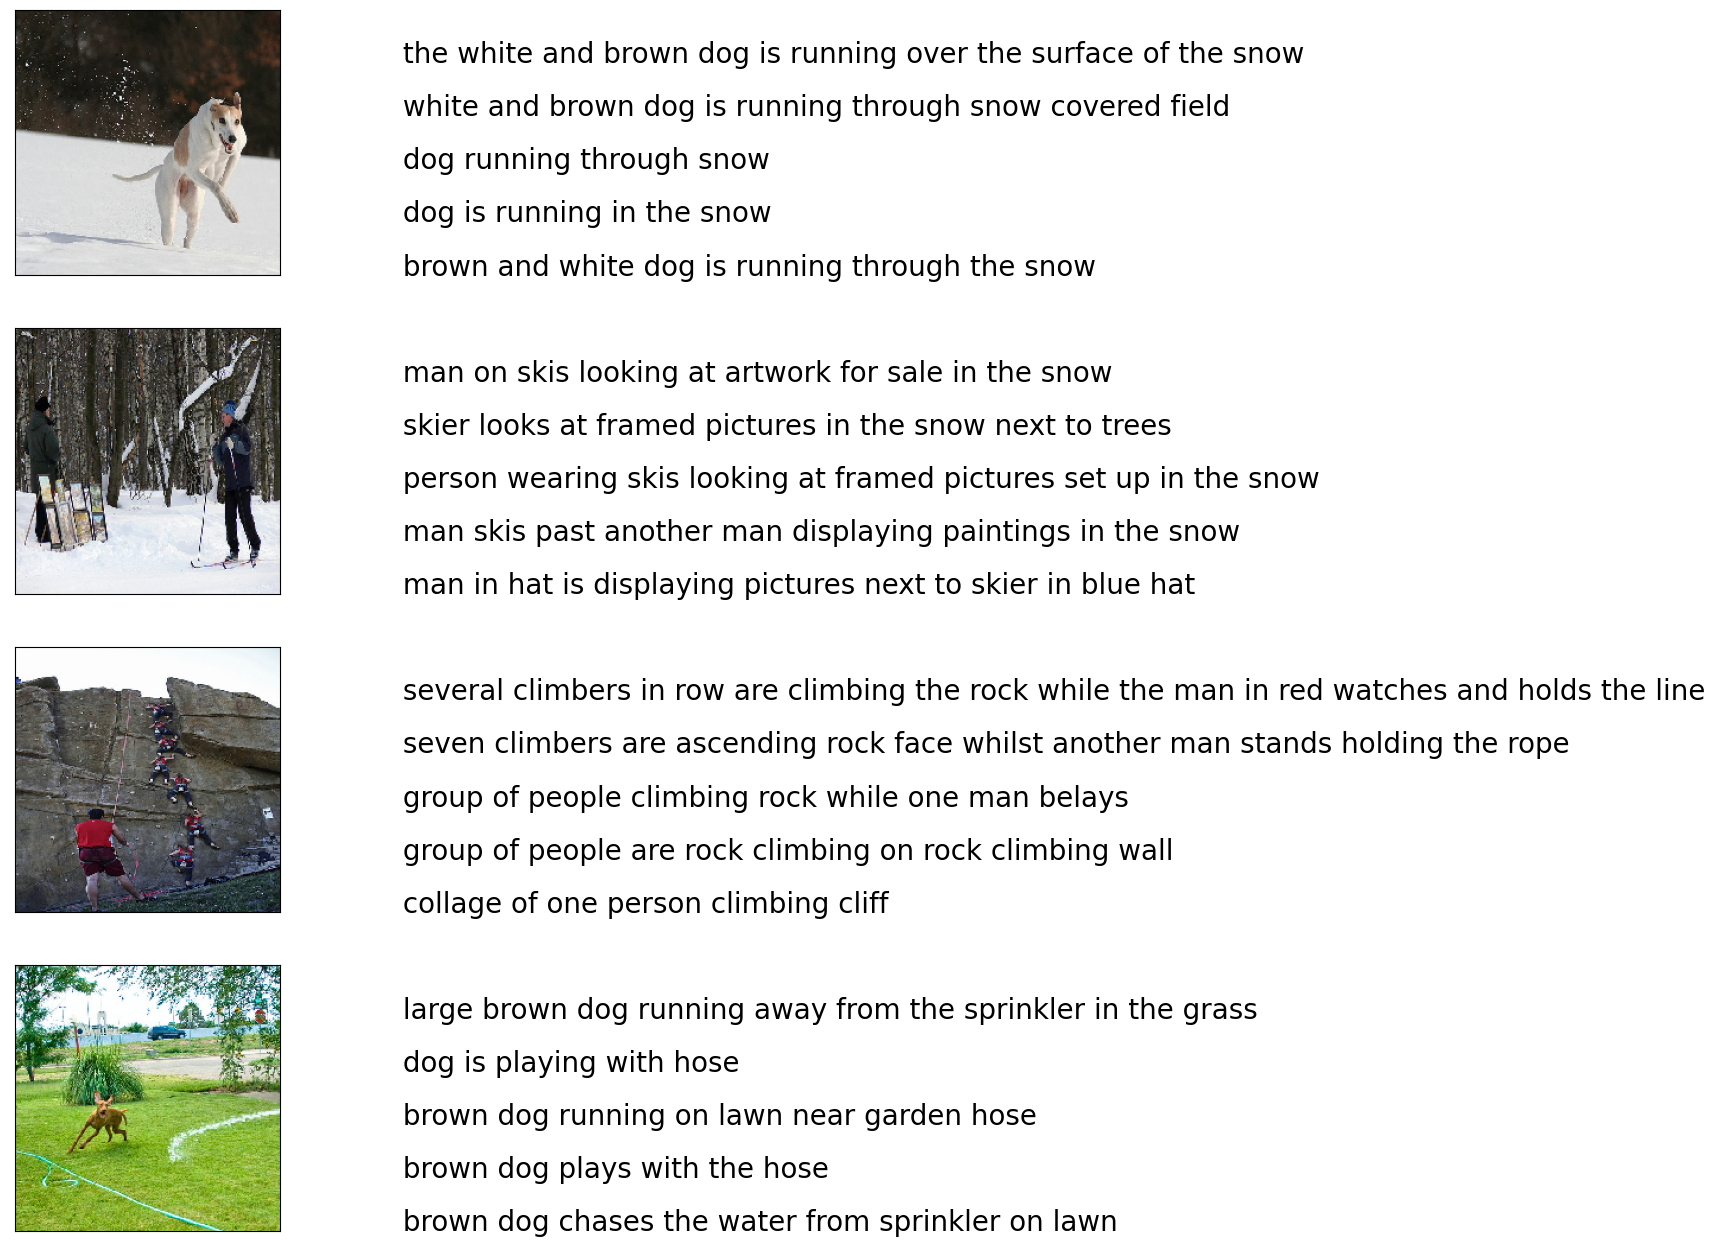

In [15]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '/' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

In [16]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [17]:
def data_limiter(num,total_captions,all_img_name_vector):
 train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
 train_captions = train_captions[:num]
 img_name_vector = img_name_vector[:num]
 return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [18]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = ResNet152V2(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = Model(new_input, hidden_layer)

image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

                                                                                                  
 conv2_block2_out (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_conv[0][0]']    
                                                                                                  
 conv2_block3_preact_bn (BatchN  (None, None, None,   1024       ['conv2_block2_out[0][0]']       
 ormalization)                  256)                                                              
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, None, None,   0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                        256)                                                              
                                                                                                  
 conv2_blo

                                128)                             ]                                
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, None, None,   0          ['conv3_block2_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_2_pad (ZeroPaddin  (None, None, None,   0          ['conv3_block2_1_relu[0][0]']    
 g2D)                           128)                                                              
          

 conv3_block4_2_relu (Activatio  (None, None, None,   0          ['conv3_block4_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block4_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block4_2_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv3_block4_out (Add)         (None, None, None,   0           ['conv3_block3_out[0][0]',       
                                512)                              'conv3_block4_3_conv[0][0]']    
                                                                                                  
 conv3_block5_preact_bn (BatchN  (None, None, None,   2048       ['conv3_block4_out[0][0]']       
 ormalizat

                                                                                                  
 conv3_block7_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block7_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block7_1_relu (Activatio  (None, None, None,   0          ['conv3_block7_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block7_2_pad (ZeroPaddin  (None, None, None,   0          ['conv3_block7_1_relu[0][0]']    
 g2D)                           128)                                                              
                                                                                                  
 conv3_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, None, None,   0          ['conv4_block1_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, None, None,   525312      ['conv4_block1_preact_relu[0][0]'
                                1024)                            ]                                
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block1_2_relu[0][0]']    
                                1024)                                                             
          

 conv4_block4_preact_relu (Acti  (None, None, None,   0          ['conv4_block4_preact_bn[0][0]'] 
 vation)                        1024)                                                             
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, None, None,   262144      ['conv4_block4_preact_relu[0][0]'
                                256)                             ]                                
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block4_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, None, None,   0          ['conv4_block4_1_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block6_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_blo

 vation)                        1024)                                                             
                                                                                                  
 conv4_block9_1_conv (Conv2D)   (None, None, None,   262144      ['conv4_block9_preact_relu[0][0]'
                                256)                             ]                                
                                                                                                  
 conv4_block9_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block9_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block9_1_relu (Activatio  (None, None, None,   0          ['conv4_block9_1_bn[0][0]']      
 n)                             256)                                                              
          

 conv4_block11_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block11_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block11_2_relu (Activati  (None, None, None,   0          ['conv4_block11_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block11_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block11_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block11_out (Add)        (None, None, None,   0           ['conv4_block10_out[0][0]',      
          

                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, None, None,   262144      ['conv4_block14_preact_relu[0][0]
                                256)                             ']                               
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block14_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block14_1_relu (Activati  (None, None, None,   0          ['conv4_block14_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

 lization)                      256)                                                              
                                                                                                  
 conv4_block16_2_relu (Activati  (None, None, None,   0          ['conv4_block16_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block16_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block16_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block16_out (Add)        (None, None, None,   0           ['conv4_block15_out[0][0]',      
                                1024)                             'conv4_block16_3_conv[0][0]']   
          

 conv4_block19_1_conv (Conv2D)  (None, None, None,   262144      ['conv4_block19_preact_relu[0][0]
                                256)                             ']                               
                                                                                                  
 conv4_block19_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block19_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block19_1_relu (Activati  (None, None, None,   0          ['conv4_block19_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block19_2_pad (ZeroPaddi  (None, None, None,   0          ['conv4_block19_1_relu[0][0]']   
 ng2D)    

                                                                                                  
 conv4_block21_2_relu (Activati  (None, None, None,   0          ['conv4_block21_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block21_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block21_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block21_out (Add)        (None, None, None,   0           ['conv4_block20_out[0][0]',      
                                1024)                             'conv4_block21_3_conv[0][0]']   
                                                                                                  
 conv4_blo

                                256)                             ']                               
                                                                                                  
 conv4_block24_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block24_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block24_1_relu (Activati  (None, None, None,   0          ['conv4_block24_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block24_2_pad (ZeroPaddi  (None, None, None,   0          ['conv4_block24_1_relu[0][0]']   
 ng2D)                          256)                                                              
          

 conv4_block26_2_relu (Activati  (None, None, None,   0          ['conv4_block26_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block26_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block26_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block26_out (Add)        (None, None, None,   0           ['conv4_block25_out[0][0]',      
                                1024)                             'conv4_block26_3_conv[0][0]']   
                                                                                                  
 conv4_block27_preact_bn (Batch  (None, None, None,   4096       ['conv4_block26_out[0][0]']      
 Normaliza

                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block29_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block29_1_relu (Activati  (None, None, None,   0          ['conv4_block29_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block29_2_pad (ZeroPaddi  (None, None, None,   0          ['conv4_block29_1_relu[0][0]']   
 ng2D)                          256)                                                              
                                                                                                  
 conv4_blo

 on)                            256)                                                              
                                                                                                  
 conv4_block31_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block31_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block31_out (Add)        (None, None, None,   0           ['conv4_block30_out[0][0]',      
                                1024)                             'conv4_block31_3_conv[0][0]']   
                                                                                                  
 conv4_block32_preact_bn (Batch  (None, None, None,   4096       ['conv4_block31_out[0][0]']      
 Normalization)                 1024)                                                             
          

 conv4_block34_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block34_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block34_1_relu (Activati  (None, None, None,   0          ['conv4_block34_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block34_2_pad (ZeroPaddi  (None, None, None,   0          ['conv4_block34_1_relu[0][0]']   
 ng2D)                          256)                                                              
                                                                                                  
 conv4_block34_2_conv (Conv2D)  (None, None, None,   589824      ['conv4_block34_2_pad[0][0]']    
          

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, None, None,   0          ['conv4_block35_out[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block36_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block36_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block36_out (Add)        (None, None, None,   0           ['max_pooling2d_2[0][0]',        
                                1024)                             'conv4_block36_3_conv[0][0]']   
                                                                                                  
 conv5_blo

 vation)                        2048)                                                             
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, None, None,   1048576     ['conv5_block3_preact_relu[0][0]'
                                512)                             ]                                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
          

In [19]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [20]:
%%time
os.makedirs('/kaggle/flickr_features')
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

 for bf, p in zip(batch_features, path):
   path_of_feature = p.numpy().decode("utf-8")
   path_of_feature = "/kaggle/flickr_features/"+path_of_feature.split('/')[-1]
   np.save(path_of_feature, bf.numpy())

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '/kaggle/flickr_features'

In [21]:
top_k = len(clean_vocabulary)
tokenizer = Tokenizer(num_words=top_k,
                      oov_token="<unk>",
                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = pad_sequences(train_seqs, padding='post')

In [22]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


In [23]:
index = 0
for path in img_name_vector:
    img_name_vector[index] = "/kaggle/flickr_features/" + path.split('/')[-1]
    index = index + 1
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [24]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [25]:
def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [26]:
#The advantage of using Glove over Word2Vec is that 
#GloVe does not just rely on the local context of words but it incorporates global word co-occurrence to obtain word vectors
embeddings_index = {} 
f = open('glove.840B.300d.txt', encoding="utf-8")
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs


In [27]:
embedding_dim = len(list(embeddings_index.values())[0])
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [28]:
class ResNet_Encoder(Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(ResNet_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = Dense(embedding_dim)
       self.dropout = Dropout(0.5, noise_shape=None, seed=None)
   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   

In [29]:
def rnn_type(units):
   if tf.test.is_gpu_available():
       return CuDNNLSTM(units,
                        return_sequences=True,
                        return_state=True,
                        recurrent_initializer='glorot_uniform')
   else:
       return GRU(units,
                  return_sequences=True,
                  return_state=True,
                  recurrent_activation='sigmoid',
                  recurrent_initializer='glorot_uniform')

In [30]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = Embedding(vocab_size, embedding_dim, trainable=False, weights=[embedding_matrix])
   #self.embedding = Embedding(vocab_size, embedding_dim)
   self.gru = GRU(self.units,
                  return_sequences=True,
                  return_state=True,
                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = Dense(self.units)

   self.dropout = Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = Dense(vocab_size)

   # Implementing Attention Mechanism
   self.Uattn = Dense(units)
   self.Wattn = Dense(units)
   self.Vattn = Dense(1)
 def call(self, x, features, hidden):
   # features shape ==> (64,49,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   # score shape == (64, 49, 1)
   # Attention Function
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   # self.Uattn(features) : (64,49,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
   '''attention_weights(alpha(ij)) = softmax(e(ij))'''

   attention_weights = tf.nn.softmax(score, axis=1)

   # attention_weights shape == (64, 49, 1)
   # Give weights to the different pixels in the image
   ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)

   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU

   output, state = self.gru(x)
   # shape == (batch_size, max_length, hidden_size)

   x = self.fc1(output)
   # x shape == (batch_size * max_length, hidden_size)

   x = tf.reshape(x, (-1, x.shape[2]))

   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


encoder = ResNet_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [32]:

loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0
 # initializing the hidden state for each batch
 # because the captions are not related from image to image

 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         # using teacher forcing
         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

In [40]:
import time 
EPOCHS = 20
elapsed_start = time.time()
for epoch in range(0, EPOCHS):
   start = time.time()
   total_loss = 0

   for (batch, (img_tensor, target)) in enumerate(dataset):
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss

       if batch % 100 == 0:
           print ('Epoch {} Batch {} Loss {:.4f}'.format(
             epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
   # storing the epoch end loss value to plot later
   loss_plot.append(total_loss / num_steps)

   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
print(f'Time taken to train model: {time.time() - elapsed_start} seconds')

Epoch 1 Batch 0 Loss 2.8889
Epoch 1 Batch 100 Loss 1.5520
Epoch 1 Batch 200 Loss 1.2403
Epoch 1 Batch 300 Loss 1.2200
Epoch 1 Batch 400 Loss 1.1700
Epoch 1 Loss 1.387588
Time taken for 1 epoch 1328.7034997940063 sec

Epoch 2 Batch 0 Loss 1.1881
Epoch 2 Batch 100 Loss 1.1513
Epoch 2 Batch 200 Loss 1.1763
Epoch 2 Batch 300 Loss 1.0696
Epoch 2 Batch 400 Loss 1.0692
Epoch 2 Loss 1.075199
Time taken for 1 epoch 1206.4221670627594 sec

Epoch 3 Batch 0 Loss 1.0020
Epoch 3 Batch 100 Loss 1.0461
Epoch 3 Batch 200 Loss 0.8955
Epoch 3 Batch 300 Loss 1.0115
Epoch 3 Batch 400 Loss 0.8454
Epoch 3 Loss 0.956241
Time taken for 1 epoch 1217.919178724289 sec

Epoch 4 Batch 0 Loss 0.8081
Epoch 4 Batch 100 Loss 0.8770
Epoch 4 Batch 200 Loss 0.8462
Epoch 4 Batch 300 Loss 0.8818
Epoch 4 Batch 400 Loss 0.8830
Epoch 4 Loss 0.862598
Time taken for 1 epoch 1187.0381963253021 sec

Epoch 5 Batch 0 Loss 0.7508
Epoch 5 Batch 100 Loss 0.8233
Epoch 5 Batch 200 Loss 0.8565
Epoch 5 Batch 300 Loss 0.7718
Epoch 5 Batch 4

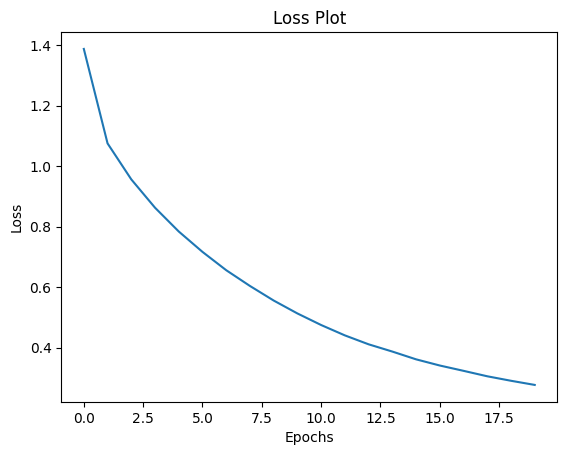

In [41]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [87]:
def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

In [43]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

In [44]:
index = 0
for path in img_name_val:
    img_name_val[index] = "../Image Captioning/DataSet/Images/" + path.split('/')[-1]
    index = index + 1

Real Caption: two people are walking two golden dogs in the snow
Prediction Caption: two people with two dogs
time took to Predict: 2 sec


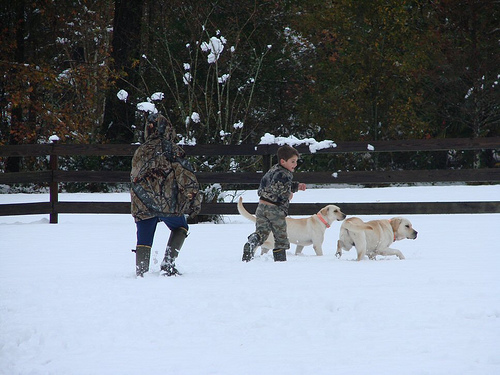

In [174]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

#plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

In [161]:
from nltk.translate.bleu_score import sentence_bleu
reference = [
    'The dogs play on the snow '.split(),
    'Two brown dogs playfully fight in the snow '.split(),
    'Two dogs playing in the snow'.split(),
    'The dogs are in the snow in front of a fence'.split() 
]
candidate = ['two', 'dogs', 'playing', 'in', 'the', 'snow']
print(candidate)

print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))


['two', 'dogs', 'playing', 'in', 'the', 'snow']
Individual 1-gram: 0.833333
Individual 2-gram: 0.800000
Individual 3-gram: 0.750000
Individual 4-gram: 0.666667


Real Caption: two black dogs play in snow
Prediction Caption: two dogs run through the snow
time took to Predict: 1 sec


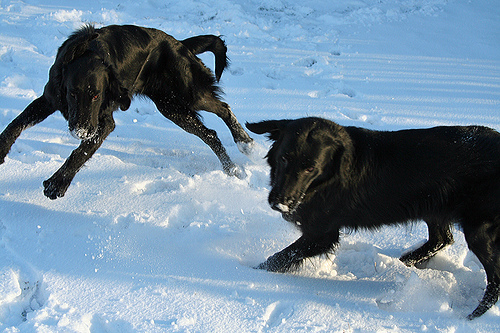

In [180]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

#plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

Real Caption: one dog is sniffing the ground by the wooden fence whist another dog is carrying frisbee in its mouth
Prediction Caption: two dogs one with frisbee
time took to Predict: 1 sec


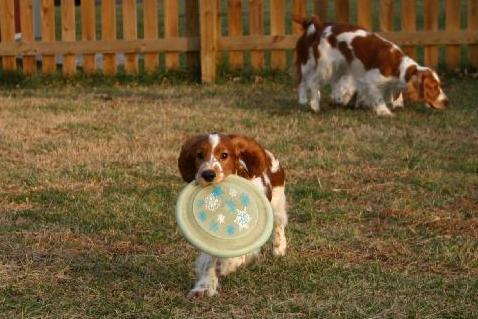

In [197]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

#plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

Real Caption: two motorcyclist racing around track
Prediction Caption: two cyclists race along the edge of roadway
time took to Predict: 1 sec


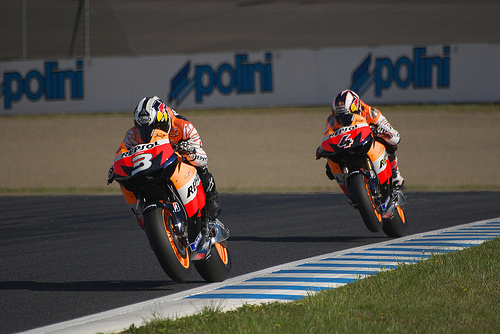

In [198]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

#plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

Real Caption: two young girls playing outside on the playground
Prediction Caption: two blonde girl playing on jungle gym
time took to Predict: 1 sec


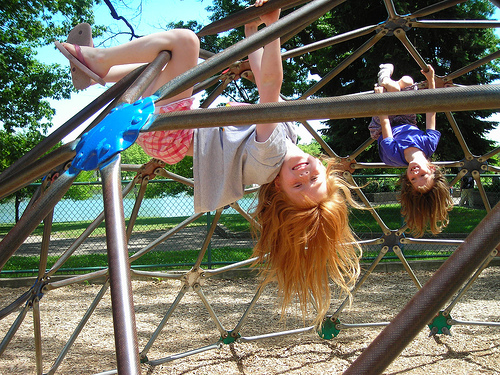

In [199]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

#plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

Real Caption: puppy jumps on bed with purple sheets
Prediction Caption: small black and black dog is on bed with blue sheets and pillow
time took to Predict: 1 sec


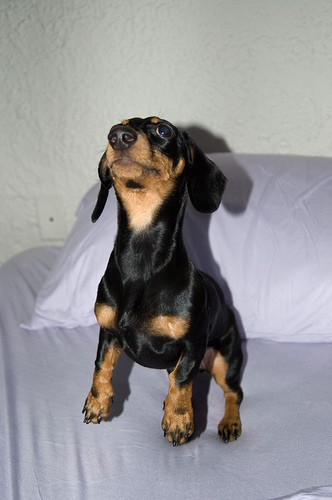

In [200]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

#plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

Real Caption: people are clustered around bonfire at night
Prediction Caption: large group of people sit around campfire at night
time took to Predict: 1 sec


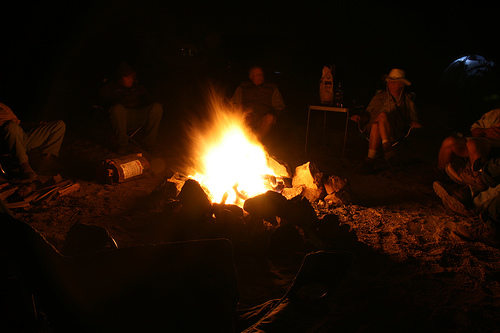

In [202]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

#plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

In [86]:
sample=evaluate('../Image Captioning/test_image9.jpg')
l=list(sample[0])
l.pop()
print(l)



TypeError: 'NoneType' object is not subscriptable

In [231]:

from nltk.translate.bleu_score import sentence_bleu
reference = [
    'The dogs play on the snow '.split(),
    'Two brown dogs playfully fight in the snow '.split(),
    'Two dogs playing in the snow'.split(),
    'The dogs are in the snow in front of a fence'.split() 
]
candidate = ['two', 'dogs', 'playing', 'in', 'the', 'snow']
print(candidate)
print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

['two', 'dogs', 'playing', 'in', 'the', 'snow']
Cumulative 1-gram: 0.833333
Cumulative 2-gram: 0.816497
Cumulative 3-gram: 0.795536
Cumulative 4-gram: 0.759836


Real Caption: group of people run down city street
Prediction Caption: group of people are jogging and seen in an urban area
time took to Predict: 4 sec


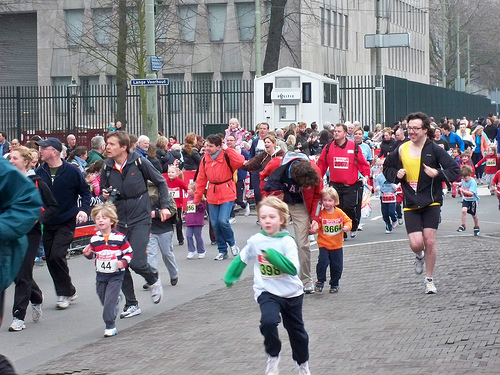

In [256]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

#plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

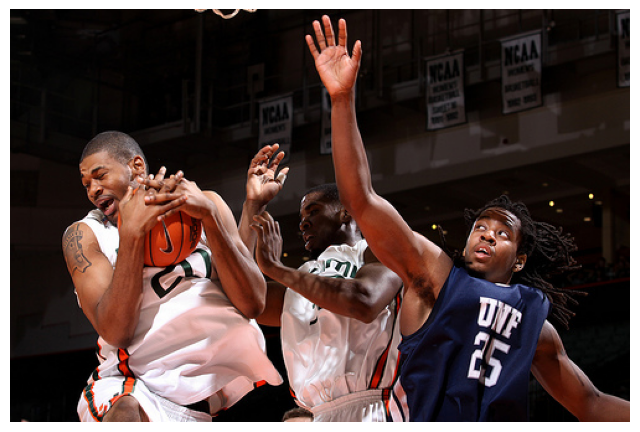

Cumulative 1-gram: 0.743038
Cumulative 2-gram: 0.655298
Cumulative 3-gram: 0.608899
Cumulative 4-gram: 0.557800


In [265]:
plt.style.use("seaborn")
  
i = plt.imread('../Image Captioning/3155451946_c0862c70cb.jpg')
    
plt.imshow(i)
plt.axis("off")
plt.show()

from nltk.translate.bleu_score import sentence_bleu
reference = [
    'Several basketball players are grabbing for the ball during a game'.split(),
    'The basketball player in white holds the ball'.split(),
    'Three basketball players leap to grab a ball'.split(),
    'Three men are playing basketball'.split() 
]
candidate =['three', 'basketball', 'players', 'leap', 'to', 'grab', 'ball']

print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

In [283]:
sample=evaluate('../Image Captioning/2064790732_219e52e19c.jpg')
l=list(sample[0])
l.pop()
print(l)

['group', 'of', 'kids', 'are', 'walking', 'around', 'adults', 'in', 'the', 'road']


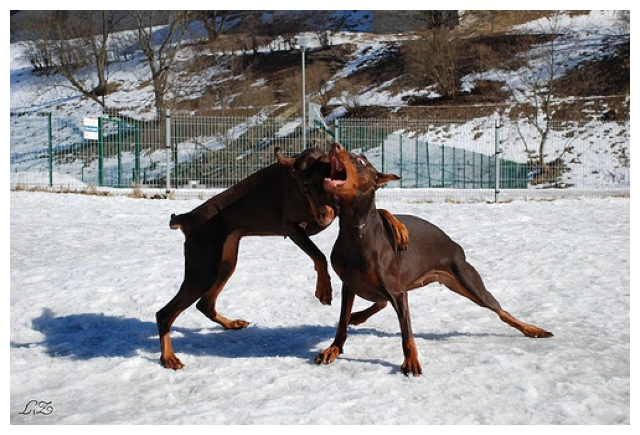

Cumulative 1-gram: 0.833333
Cumulative 2-gram: 0.816497
Cumulative 3-gram: 0.795536
Cumulative 4-gram: 0.759836


In [267]:
plt.style.use("seaborn")
  
i = plt.imread('../Image Captioning/3385593926_d3e9c21170.jpg')
    
plt.imshow(i)
plt.axis("off")
plt.show()



from nltk.translate.bleu_score import sentence_bleu
reference = [
    'The dogs play on the snow '.split(),
    'Two brown dogs playfully fight in the snow '.split(),
    'Two dogs playing in the snow'.split(),
    'The dogs are in the snow in front of a fence'.split() 
]
candidate = ['two', 'dogs', 'playing', 'in', 'the', 'snow']

print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

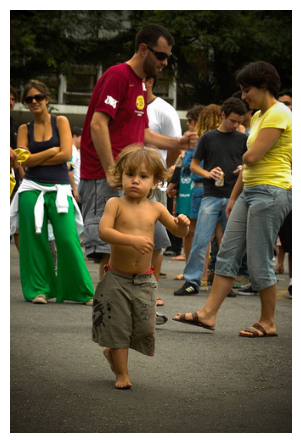

Cumulative 1-gram: 0.778801
Cumulative 2-gram: 0.721029
Cumulative 3-gram: 0.647476
Cumulative 4-gram: 0.595943


In [288]:
plt.style.use("seaborn")
  
i = plt.imread('../Image Captioning/2064790732_219e52e19c.jpg')
    
plt.imshow(i)
plt.axis("off")
plt.show()



from nltk.translate.bleu_score import sentence_bleu
reference = [
    'A boy without a shirt is running in the street while several people stand behind him '.split(),
    'A little boy dances with a group of people behind him on a city street '.split(),
    'A small boy dances on the concrete surrounded by adults '.split(),
    'The shirtless little boy is walking around adults in th road '.split() 
]
candidate = ['boy','is', 'walking', 'around', 'adults', 'in', 'the', 'road']

print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

In [46]:
sample=evaluate('../Image Captioning/2064790732_219e52e19c.jpg')
l=list(sample[0])
l.pop()
print(l)

['little', 'boy', 'and', 'one', 'holding', 'white', 'and', 'holding', 'football']


In [88]:
sample=evaluate('../Image Captioning/test_image9.jpg')
l=list(sample[0])
l.pop()
print(l)


['man', 'rides', 'wakeboard', 'attached', 'to', 'parachute']


In [55]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image

root = tk.Tk()

# Function to open and save the image
def save_image():
    filepath = filedialog.askopenfilename()
    image = Image.open(filepath)
    image.save("test_image.jpg")
    label.config(text="Image saved as test.image.")

# UI setup
label = tk.Label(root, text="Click the button to select an image .")
label.pack()

button = tk.Button(root, text="Select Image", command=save_image)
button.pack()
root.mainloop()




In [90]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk

root = tk.Tk()

# Function to open and save the image
def save_image():
    filepath = filedialog.askopenfilename()
    image = Image.open(filepath)
    image.save("test_image.jpg")
    label.config(text="Image saved as test.image.")
    photo = ImageTk.PhotoImage(image) # create a PhotoImage object
    label.config(image=photo) # update the label image
    label.image = photo
    process_image(image) # pass the image to another function

# Function to process the image
def process_image(image):
    sample=evaluate("test_image.jpg")
    l=list(sample[0])
    l.pop()
    result_label.config(text=l)
    print(l)
    

# UI setup
label = tk.Label(root, text="Click the button to select an image and save it as test.image.")
label.pack()
result_label = tk.Label(root, font=("Helvetica", 18))
result_label.pack(pady=10)

button = tk.Button(root, text="Select Image", command=save_image)
button.pack()

root.mainloop()

['three', 'basketball', 'players', 'leap', 'to', 'grab', 'ball']


In [89]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk

root = tk.Tk()

# Function to open and save the image
def save_image():
    filepath = filedialog.askopenfilename()
    image = Image.open(filepath)
    image.save("test_image.jpg")
    label.config(text="Image saved as test.image.")
    photo = ImageTk.PhotoImage(image) # create a PhotoImage object
    image_label.config(image=photo) # update the image label
    image_label.image = photo
    process_image("test_image.jpg") # pass the image file path to the evaluate function

# Function to process the image
def process_image(image_path):
    sample = evaluate(image_path) # evaluate the image
    l = list(sample[0])
    l.pop()
    result_label.config(text=l) # update the result label

# Function to evaluate the image


# UI setup
root.geometry("400x400")

label = tk.Label(root, text="Click the button to select an image and save it as test.image.", font=("Helvetica", 14))
label.pack(pady=10)

image_label = tk.Label(root)
image_label.pack()

result_label = tk.Label(root, font=("Helvetica", 18))
result_label.pack(pady=10)

button = tk.Button(root, text="Select Image", font=("Helvetica", 14), command=save_image)
button.pack(pady=10)

root.mainloop()